# Dizel fiyatları ne kadar yüksek? EIA ile TCMB veritabanını birleştirmek

Bu derste daha önce nasıl bağlanacağımızı gördüğümüz iki veritabanından farklı verileri alıp, aynı tarihlerde birleştirerek bir analiz yapacağız.
Sırasıyla:
* EIA veritabanından günlük Brent, WTI ve Los Angeles dizel (ULSD-ultra low sulphur diesel) 
* TCMB'den günlük ABD doları TL kurunu çekmek
* İki veri setini aynı tarihlerde birleştirme
* ÖTV ve KDV ekleyerek nihai yakıt fiyatını bulma
konularını işleyeceğiz. Gerçek hayatta akaryakıt fiyatları "en yakın erişilebilir piyasa" olarak Genova'yı gördüğü için ABD fiyatları ile bizim fiyatların bir ilişkisi yoktur. Sadece bir analiz yöntemi.

## EIA veritabanından veri çekmek

Daha önce incelediğimiz gibi EIA veri tabanından veri çekmek için "EIAdata" kütüphanesini kullanıyoruz. Eğer bu kütüphane yüklü değilse aşağıdaki komut ile yüklüyoruz. 

In [ ]:
install.packages("EIAdata")

Yüklediyseniz ve bir sorun olmadı ise kütüphaneyi kullanacağımızı bildirerek programa başlayalım.

In [1]:
library("EIAdata")

Loading required package: XML
Loading required package: plyr
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



R dersleri 12'de anlatıldığı gibi [EIA'dan data](http://www.barissanli.com/calismalar/dersler/r/rders12.php) EIA veri erişimi için email adresinizi girerek veri anahtarını alın. Ben kendi anahtarımı kendime saklayacağım, bu sebeple sahte bir XXXXX anahtarı yazıyorum. Bu anahtarla program çalışmaz, veri çekemezsiniz. 

**KENDİ ANAHTARINIZI ALIN ve XXXXXXXX YERİNE YAZIN**

In [3]:
keyEIA<-"XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

## Hangi Verileri Alacağız

EIA'nın, yine ders 12'de anlatıldığı şekilde veri kataloğundan ilgili verilerin kodlarını buluyoruz.
Ben google'da "eia spot prices" yazarak gelen sayfaya tıklıyorum. [Bu sayfa](https://www.eia.gov/dnav/pet/pet_pri_spt_s1_d.htm) . Burada anahtar ikonunun üzerine gelerek veya tıklayarak açılan web adresinin son kısmına bakıyorum:

Kullanacağım ürünler ve kodları, günlük olarak (dikkat ederseniz kodların sonu hep ".D" ile bitiyor)
* WTI petrol için PET.RWTC.D
* Brent petrol için RBRTE.D
* Los Angeles limanı teslim ultra düşük kükürtlü dizel (ULSD) için PET.EER_EPD2DC_PF4_Y05LA_DPG.D
* New York limanı teslim ULSD için PET.EER_EPD2DXL0_PF4_Y35NY_DPG.D

EIA'dan çekeceğimiz 3 veri bu kadar. Maalesef veriler için bir tarih aralığı veremiyoruz. Sistem otomatik ne bulduysa çekiyor.

Verileri *getEIA* komutu ile çekiyoruz, istediğimiz veri kodunu girdikten sonra anahtarımızın yeraldığı değişkenin de ismini yazmayı unutmayın, yoksa veri gelmez. Hata verir. 

Kısaca **getEIA(ID=verikodu, key=anahtarınız)**

In [6]:
wti=getEIA(ID = "PET.RWTC.D", key = keyEIA) # WTI
brent=getEIA(ID = "PET.RBRTE.D", key = keyEIA) # Brent
dizel=getEIA(ID = "PET.EER_EPD2DC_PF4_Y05LA_DPG.D", key = keyEIA) # New York Dizel 

3 ayrı veri geldi. şimdi verileri ister mesela:

* head(wti) diye başlarına bakabiliriz.
* plot(wti) diye grafikleyebiliriz de...

Ben önce bu üç veri setini *merge* komutu ile birleştirmeyi seçiyorum. merge aynı tarih olacak şekilde 3 veri setini birleştiriyor ve bunu da *toplam* değişkenine atıyorum

In [9]:
toplam<-merge(wti,brent,dizel)

Eğer bu noktaya kadar herhangi bir sorun yaşamadıysanız verilerin baş kısmına bakalım. Unutmayın 

* head komutu ile verinin baş kısmına
* tail komutu ile verinin son kısmına bakabiliyoruz

*head* ile baktığımızda bir kısım verilerin mesela Brent ve LA fiyatlarının olmadığını görürürüz

In [10]:
head(toplam)

           PET.RWTC.D PET.RBRTE.D PET.EER_EPD2DC_PF4_Y05LA_DPG.D
1986-01-02      25.56          NA                             NA
1986-01-03      26.00          NA                             NA
1986-01-06      26.53          NA                             NA
1986-01-07      25.85          NA                             NA
1986-01-08      25.87          NA                             NA
1986-01-09      26.03          NA                             NA

Şimdi bir de en son hangi veriler varmış, *tail* komutu ile bakalım.

In [11]:
tail(toplam)

           PET.RWTC.D PET.RBRTE.D PET.EER_EPD2DC_PF4_Y05LA_DPG.D
2017-11-13      56.77       62.94                          2.022
2017-11-14      55.67       60.91                          1.983
2017-11-15      55.28       61.25                          1.964
2017-11-16      55.14       61.18                          1.935
2017-11-17      56.21       61.34                          1.941
2017-11-20      56.21       61.34                          1.941

Ne olur ne olmaz diye verileri bir defa saklayalım, bir daha internete bağlanıp veri indirme derdimiz olmasın. Bunun için "saveRDS" komutu, okumak için de "readRDS" komutunu kullanıyoruz

In [12]:
saveRDS(toplam,"20171122toplam.rds")

## Veri setlerini zaman serilerine çevirmek

Burada öncelikle *toplam* değişkenimizin ne cins bir değişken olduğuna bakalım

In [14]:
class(toplam)

[1] "xts" "zoo"

Eğer veriyi geri çekmemiz gerekirse readRDS'de daima xts kütüphanesini ve *as.xts* komutunu kullanmamız gerekecek.
Bu satırı **ÇALIŞTIRMAYIN** sadece başlamak isterseniz buradan başlayabilirsiniz

In [ ]:
#------------------------------------
# program buradan da çalışır
#------------------------------------
library(xts)
toplam<-as.xts(readRDS("20171122toplam.rds"))
head(toplam)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



             WTI Brent LADizel WTI2Dizel Brent2Dizel
2006-06-14 69.12 65.52   2.104  1.278472    1.994417
2006-06-15 69.78 66.04   2.105  1.266982    1.992178
2006-06-16 69.75 65.01   2.088  1.257290    1.946106
2006-06-19 69.21 66.40   2.041  1.238578    1.958133
2006-06-20 69.30 67.57   2.048  1.241212    1.996874
2006-06-21 70.07 68.17   2.076  1.244356    2.019708

## Sütunlardaki eksikleri bulmak, hesap yapmak, yeni sütun eklemek

Bu kısımda ben teknik bir hesap yapıyorum. 

* 1 varil petrol 42 gallon'a eşit. 
* ABD'de yakıtlar gallon üzerinden hesaplanıyor. 
* Ben 1 gallon WTI petrolün 1 gallon dizel'e oranını buluyorum.

Kısaca 
Daha önce de yaptığım gibi burada internetten aldığım verileri korumak için tüm **toplam** değişkenini **ytoplam** değişkenine atıyorum. Artık işlemlere **ytoplam** üzerinden devam edeceğim.

Ardından *ytoplam[,3]* ile 3. sütunda yer alan dizel fiyatını, *ytoplam[,1]* de yer alan WTI fiyatının 42'ye bölünmesi sonucu bulunan 1 gallon WTI fiyatına bölüyorum.
Bölümü yeni sütun olarak **wti2diesel** sütununa aktarıyorum.

In [16]:
ytoplam<-toplam
ytoplam$wti2diesel<-ytoplam[,3]/(ytoplam[,1]/42)

Tüm veriler yerinde mi diye **head** komutu ile bakabilirim. 

* head(ytoplam)

Eğer herşey yerinde ve en sona **wti2diesel** sütunu eklendi ise her şey yolundadır demektir.

Fakat burada bazı satırlarda veri olmayabilir veya sonuçsuz satırlar olabilir. **complete.cases** komutu ile eğer bir satırdaki tüm değişkenler tam ise o satır numarasını geri dönen, değilse satır numarasını vermeyen/atlayan bir komut.

Aşağıdaki komut ile yeni tablomuzda sadece *tüm değişkenlerin* olduğu satırları *temizyeni* değişkenine atıyoruz.

In [18]:
temizyeni<- ytoplam[complete.cases(ytoplam),]


Şimdi temiz yeni değişkeninin ilk satırlarına **head** komutu ile bir bakalım

In [20]:
head(temizyeni)

           PET.RWTC.D PET.RBRTE.D PET.EER_EPD2DC_PF4_Y05LA_DPG.D wti2diesel
1996-04-17      24.67       19.88                          0.905   1.540738
1996-04-18      23.47       19.33                          0.930   1.664252
1996-04-19      23.96       19.53                          0.940   1.647746
1996-04-22      23.94       19.38                          0.960   1.684211
1996-04-23      24.39       20.88                          0.955   1.644526
1996-04-24      24.00       20.73                          0.960   1.680000

## 1 Gallon Los Angeles dizelin 1 gallon ham petrole oranını grafiklemek

Daha önceki R derslerinde görmüştük. Tekrar edelim. Tüm verilerin olduğu *temizyeni* tablosundaki *wti2diesel* sütununu seçmek için:

* temizyeni\$wti2diesel yazıyoruz. *"$"* yani dolar çok kritik, temizyeni altındaki wti2diesel sütunu demek

**Plot** komutunda bir ayrıntı yok zaten, değişken sütunu veriyoruz, bir de grafik başlığını. Plot için özel bir kütüphane kullanmaya da gerek yok.


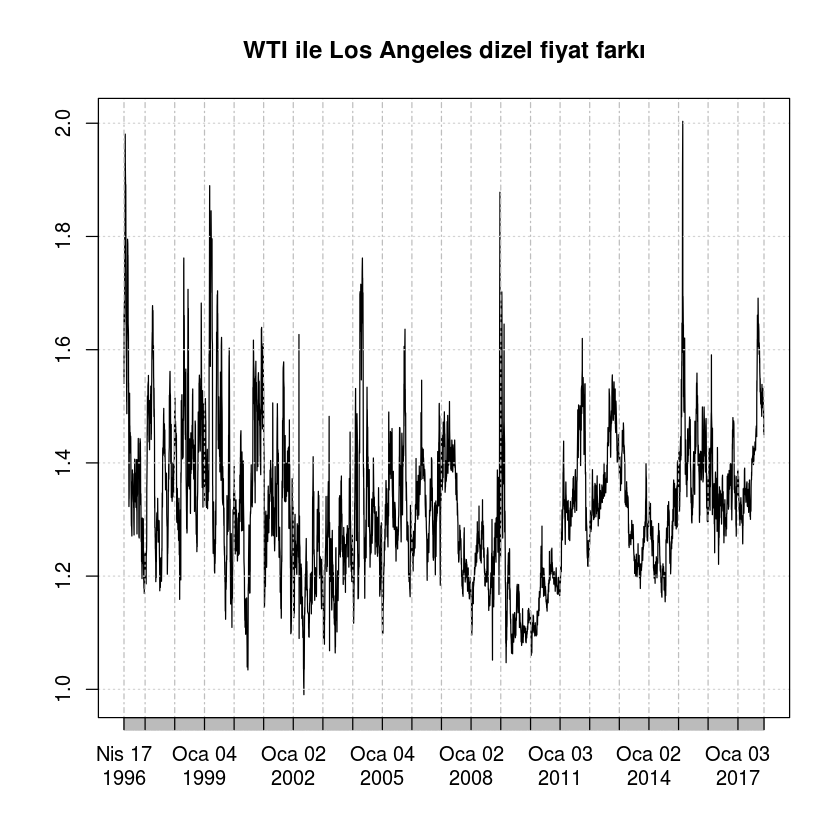

In [21]:
plot(temizyeni$wti2diesel, main ="WTI ile Los Angeles dizel fiyat farkı")

Bazen grafik çok anlamlı olmayabilir. Bir de hesabın yani 1 gallon WTI ham petrolün 1 gallon dizel'e oranının istatistiksel özelliklerine bakalım.

Bunun için de **summary** komutunu kullanacağız

In [22]:
summary(temizyeni$wti2diesel)

     Index              wti2diesel    
 Min.   :1996-04-17   Min.   :0.9906  
 1st Qu.:2001-09-27   1st Qu.:1.2296  
 Median :2007-03-05   Median :1.3123  
 Mean   :2007-02-19   Mean   :1.3218  
 3rd Qu.:2012-07-18   3rd Qu.:1.3970  
 Max.   :2017-11-20   Max.   :2.0034  

Ayni hacimde WTI ham petrolü, LA dizelin 1.32'de biri gibi diye düşünebiliriz.

## Aynı dizeli Brent'den elde etseydik...

Şimdi WTI'dan dizel çarpanını bulduğumuz için, bu çarpan ile 1 gallon Brent fiyatını çarparsak Brent'ten aynı dizelin elde edilme fiyatını buluruz.

**DİKKAT:** Farklı hampetrol, farklı rafinerilerde veya aynı rafinerilerde aynı ürünü vermez. Burada bir kabul yapıyoruz

Brent verileri hatırlayacağımız gibi 2.sütundaydı. 1 gallon Brent fiyatını bulmak için 2.sütunu 42'ye bölüyoruz:

* (temizyeni[,2]/42) : 2.sütundaki veriyi (Brent)'i 42'ye bölerek 1 varilden 1 gallon'a geç


In [24]:
# Peki Brent'e göre o dizel kaç olmalı
temizyeni$brent2diesel<-temizyeni$wti2diesel*(temizyeni[,2]/42)

Şimdi Brent'ten dizel fiyatını bulduğumuza göre, WTI'dan elde edilen LA Dizel ile Brent'ten biz bu dizeli elde etseydik fiyatını görelim. Son haftalarda durum ne olmuş: *tail* komutu

In [26]:
tail(temizyeni)

           PET.RWTC.D PET.RBRTE.D PET.EER_EPD2DC_PF4_Y05LA_DPG.D wti2diesel
2017-11-13      56.77       62.94                          2.022   1.495931
2017-11-14      55.67       60.91                          1.983   1.496066
2017-11-15      55.28       61.25                          1.964   1.492185
2017-11-16      55.14       61.18                          1.935   1.473885
2017-11-17      56.21       61.34                          1.941   1.450311
2017-11-20      56.21       61.34                          1.941   1.450311
           brent2diesel
2017-11-13     2.241759
2017-11-14     2.169652
2017-11-15     2.176103
2017-11-16     2.146959
2017-11-17     2.118145
2017-11-20     2.118145

## Grafik çizdirmek ve çizilen grafik alanını belirlemek

Ben de genelde 4. veya 5. satırdan sonraki satırlar bir alt kısma kayıyor. Ama grafik çizdirirken, çizdirmek istediğim:

* 3.sütundaki PET.EER vs diye başlayan Los Angeles dizel rakamı ile
* 5. sütunda yer alan Brent'ten dizel elde etseydik fiyatı ne oldu hesabını

aynı grafikte çizdirmek istiyorum. Böylelikle WTI'dan elde edilen LA Dizel'inin, Brent'ten elde edilseydi fiyatı ne olurdu çözümünü bulacağım. 

Bunun için önce 3. sütunu plot ile çizdiriyorum, sonra lines ile 5.sütunu ekliyorum. Ekrana sığsın diye "Jupyter Notebook" kullandığımdan "options" komutu ile çizim alanını inç cinsinden belirliyorum.

Burada plot ile ilk grafiği çizdirip, sonra legend ekleyerek sonra da doğru olarak "lines"'ı çizdiriyorum

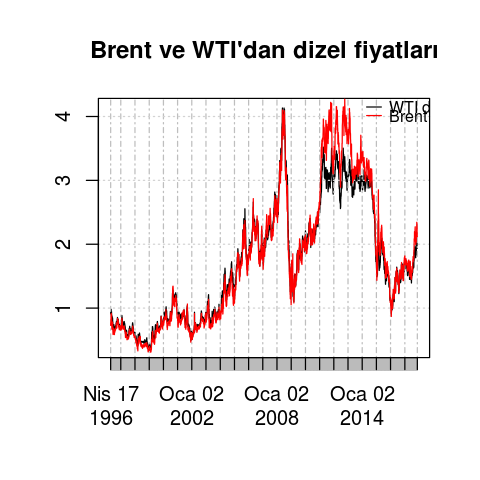

In [35]:
options(repr.plot.width=4, repr.plot.height=4)

plot(temizyeni[,3], main ="Brent ve WTI'dan dizel fiyatları")  # Önce LA Dizeli çizdirelim
# legend('topright', names(temizyeni[,c(3,5)]) ,col=c("black", "red"),  cex=0.8, lty=1, bty='n')
legend('topright', c("WTI dizel","Brent dizel") ,col=c("black", "red"),  cex=0.8, lty=1, bty='n')
lines(temizyeni[,5], col="red")


In [36]:
head(temizyeni)

           PET.RWTC.D PET.RBRTE.D PET.EER_EPD2DC_PF4_Y05LA_DPG.D wti2diesel
1996-04-17      24.67       19.88                          0.905   1.540738
1996-04-18      23.47       19.33                          0.930   1.664252
1996-04-19      23.96       19.53                          0.940   1.647746
1996-04-22      23.94       19.38                          0.960   1.684211
1996-04-23      24.39       20.88                          0.955   1.644526
1996-04-24      24.00       20.73                          0.960   1.680000
           brent2diesel
1996-04-17    0.7292825
1996-04-18    0.7659523
1996-04-19    0.7662020
1996-04-22    0.7771429
1996-04-23    0.8175646
1996-04-24    0.8292000

## Veriye yeniden şekil vermek

Verimizin böyle garip isimlere sahip sütunlardan yer alması hoş değil. Önce wti2diesel sütununu kaldıralım. Çünkü o çarpanı Brent'ten dizel hesaplamak için kullandık ve işi bitti. Bir sütunu silmek için o sütuna "NULL" atıyoruz.

In [38]:
temizyeni$wti2diesel<-NULL

Şimdi verimizdeki sütun isimlerine *"names"* komutu ile bakalım.

In [39]:
names(temizyeni)

[1] "PET.RWTC.D"                     "PET.RBRTE.D"                   
[3] "PET.EER_EPD2DC_PF4_Y05LA_DPG.D" "brent2diesel"

Sütunlarımıza yeni ve anlaşılır isimler verelim. Pratikte 4 sütunumuz var: WTI, Brent, LADizel ve Brent2Diesel (yani Brent'den elde edilecek dizel fiyatı)

In [41]:
colnames(temizyeni)<-c("WTI","Brent","LADizel","Brent2Dizel")

Son değişikliklerden sonra bakalım verilerimiz ne oldu. İsterseniz benim açıklama **#** işareti ile başlayan satırı da çalıştırarak değişkenleri saklayabilirsiniz. Ben tercih etmedim. Verilerimiz 17 Nisan 1996'dan başlıyor, 20 KAsım 2017'ye kadar devam ediyor. Son verileri görmek için hep *tail* komutunu kullanıyoruz

In [43]:
head(temizyeni)
#saveRDS(temizyeni,"20171123-temizyeni.rds")

             WTI Brent LADizel Brent2Dizel
1996-04-17 24.67 19.88   0.905   0.7292825
1996-04-18 23.47 19.33   0.930   0.7659523
1996-04-19 23.96 19.53   0.940   0.7662020
1996-04-22 23.94 19.38   0.960   0.7771429
1996-04-23 24.39 20.88   0.955   0.8175646
1996-04-24 24.00 20.73   0.960   0.8292000

In [44]:
tail(temizyeni)

             WTI Brent LADizel Brent2Dizel
2017-11-13 56.77 62.94   2.022    2.241759
2017-11-14 55.67 60.91   1.983    2.169652
2017-11-15 55.28 61.25   1.964    2.176103
2017-11-16 55.14 61.18   1.935    2.146959
2017-11-17 56.21 61.34   1.941    2.118145
2017-11-20 56.21 61.34   1.941    2.118145

# Merkez Bankasından son kur verilerini almak

Daha önce TCMB verilerine nasıl erişeceğimizi [ders 11'de](http://barissanli.com/calismalar/dersler/r/rders11.php) anlatmıştık. Orada verileri XML olarak almıştık. Şimdi ise yine aynı fonksiyonlarla bu sefer veriyi CSV olarak almaya çalışacağız.

** LÜTFEN 11. DERSTEKİ İLK KISIMDAKİ TC MERKEZ BANKASI SAYFASINDAN KENDİ ANAHTARINIZI ALIN **

Önce jenerik olan TCMB'den veri çekme fonksiyonumuzu yazalım. Bunun için RCurl ve daha sonra da kullanacağımız plyr kütüphanelerini kullanacağız. Eğer bu kütüphaneler yok ise hata verecektir. O zaman

In [ ]:
install.packages("RCurl")
install.packages("plyr")

ile ilgili kütüphaneleri kurun, daha sonra aşağıdaki gibi ilgili kütüphaneleri çağırarak tcmb_evds fonksiyonunu sisteme tanıtalım. 

In [46]:
library(RCurl)
library(plyr)


tcmb_evds<-function(veriseti,baslangic,son, anahtar) {
    adres="https://evds2.tcmb.gov.tr/service/evds/"
    seri=paste("series=",veriseti, sep="")
    tarihler=paste("&startDate=",baslangic,"&endDate=",son, sep="")
    tamamlayici=paste("&type=csv&key=",anahtar, sep="")
    veriadresi<-paste(adres,seri,tarihler,tamamlayici, sep="")
    xmlveri <- getURL(veriadresi, .opts = list(ssl.verifypeer = FALSE))
    return(xmlveri)
}


Loading required package: bitops


Anahtarımızı sisteme tanıtalım

In [208]:
TCMBanahtar<-"XXXXXXXXX"

Şimdi az önce fonksiyon olarak verdiğimiz tcmb_evds fonksiyonunu belirlediğimiz tarihler arasındaki ABD Dolar döviz kuru için çağıralım. Burada:

* TP.DK.USD.A : ABD Dolarının TL karşılığı

Hangi verinin hangi koda karşılık geldiğini [https://evds2.tcmb.gov.tr/](https://evds2.tcmb.gov.tr/) adresinden verileri seçerek bulabilirsiniz.

Daha önceki örneklerden farklı olarak bu sefer kuru "csv" formatında çekeceğiz. Daha önce XML almıştık.

In [ ]:
csvkur<-tcmb_evds("TP.DK.USD.A","01-01-2005", "22-11-2017",TCMBanahtar)

## TCMB'den verilen verinin temizlenmesi, zaman senkronizasyonu ve grafiklenmesi

Veriyi başarı ile çektiysek şimdi dikkatli olunması gereken kısım başlıyor.

* Veri "csv" formatında, isteyen head(csvkur) ile bakabilir
* Veriyi zaman serisi olarak sisteme tanıtmak ve ABD verisi ile birleştirmek için dikkatli olmamız gerek
* ayırıcı ","  
* **Zaman dilimi komutu tz="UTC" olarak belirtmezseniz herşey birleşince ekstra satırlar oluşur, mutlaka tz="UTC" olacak**
* Format gün-ay-yıl çünkü merkez bankası öyle gönderiyor.

Veri dönüşüm aşamalarında her noktada veri başlığına tekrar göz atmak çok önemli... O yüzden işlem sonrası tekrar *head(verikur)* yapıyoruz

In [210]:
verikur<-read.zoo(text=csvkur,header=TRUE,sep=",",index=2, tz='UTC', format="%d-%m-%Y")
head(verikur)

           TP_DK_USD_A UNIXTIME               
2005-01-01 null        {numberLong:1104534000}
2005-01-02 null        {numberLong:1104620400}
2005-01-03 1.3363      {numberLong:1104706800}
2005-01-04 1.3383      {numberLong:1104793200}
2005-01-05 1.3427      {numberLong:1104879600}
2005-01-06 1.3775      {numberLong:1104966000}

Son satır olan UNIXTIME'ı siliyoruz, kısaca sütun adına NULL atayınca sütun gidiyor

In [211]:
verikur$UNIXTIME<-NULL

Tekrar verimize bakalım

In [212]:
head(verikur)

           TP_DK_USD_A
2005-01-01 null       
2005-01-02 null       
2005-01-03 1.3363     
2005-01-04 1.3383     
2005-01-05 1.3427     
2005-01-06 1.3775     

Şimdi verimizde "null" yazan satırlar var, bu satırların hepsini silerek verikur'daki verilerimizi zaman serisine dönüştürüyoruz. Aşağıdaki 3 satırda sırasıyla:
* ilk sütun (TP_DK_USD_A)'nın "null"'e eşit olmadığı satırları bulup verikur değişkeni üzerine yazıyoruz
* verikur değişkenini **as.xts** fonksiyonu ile zaman serisine dönüştürüyoruz
* gerçekten dönüştü mü diye cinsini sorguluyoruz **class** komutu ile

In [213]:
verikur<-verikur[verikur[,1]!="null",]
kur<-as.xts(verikur)
class(kur)

[1] "xts" "zoo"

Şimdi de ABD dolar kurunun grafiğini çizelim

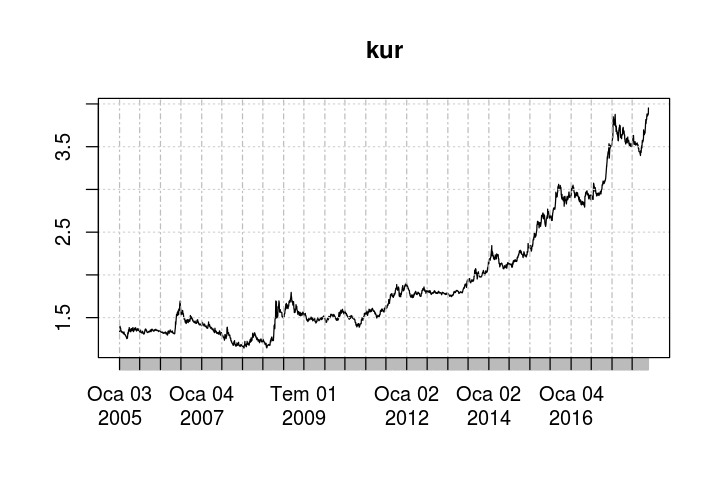

In [214]:
plot(kur)


## Merkez Bankası verisi ile EIA petrol verisini birleştirmek

Daha önceki kısımlarda EIA'dan alıp daha sonra da hesapladığımız WTI, Brent, Los Angeles Dizel ve hesap ile bulduğumuz Brent'ten dizel sütunlarını içeren **temizyeni** ile az önce zaman serisine dönüştürdüğümüz TCMB döviz kuru **kur** tablolarını **merge** komutu ile birleştiriyoruz.

In [215]:
yeni<-NULL
yeni<-merge(temizyeni,kur)

Yeni tablomuzdaki en son değişkenlere bir bakalım

In [217]:
tail(yeni)

             WTI Brent LADizel Brent2Dizel    kur
2017-11-15 55.28 61.25   1.964    2.176103 3.8664
2017-11-16 55.14 61.18   1.935    2.146959 3.8836
2017-11-17 56.21 61.34   1.941    2.118145 3.8684
2017-11-20 56.21 61.34   1.941    2.118145 3.8792
2017-11-21    NA    NA      NA          NA 3.8872
2017-11-22    NA    NA      NA          NA 3.9525

Eğer satırlardaki tüm veriler tam değil ise, yani satırda en az 1 veri bir NA (yok) ise satırı verisetinden kaldırıyoruz. Bunun için tekrar **complete.cases** komutunu kullanıyoruz.

In [218]:
yeni<-yeni[complete.cases(yeni), ]

Şimdi de belirli aralıktaki verileri istediğimizi belirtelim

**Bu noktadan sonra hata yapmak kolaylaşabilir, o yüzden daha yavaş ilerleyeceğim **

In [219]:
yeni.subset=seq.Date(as.Date("2005-01-01"),as.Date("2017-11-22"),by="day")
yeni<-yeni[as.character(yeni.subset),]

Veriyi 2005 sonrası olarak alarak sınırlandırdık. Şimdi tekrar verinin önüne arkasına bakalım

In [220]:
head(yeni)

             WTI Brent LADizel Brent2Dizel    kur
2005-01-04 43.96 40.75   1.165    1.079931 1.3383
2005-01-05 43.41 41.00   1.140    1.076710 1.3427
2005-01-06 45.51 43.25   1.190    1.130905 1.3775
2005-01-07 45.32 43.28   1.190    1.136434 1.4000
2005-01-10 45.31 44.71   1.193    1.177202 1.3723
2005-01-11 45.66 43.45   1.195    1.137161 1.3822

In [221]:
tail(yeni)

             WTI Brent LADizel Brent2Dizel    kur
2017-11-13 56.77 62.94   2.022    2.241759 3.8644
2017-11-14 55.67 60.91   1.983    2.169652 3.8659
2017-11-15 55.28 61.25   1.964    2.176103 3.8664
2017-11-16 55.14 61.18   1.935    2.146959 3.8836
2017-11-17 56.21 61.34   1.941    2.118145 3.8684
2017-11-20 56.21 61.34   1.941    2.118145 3.8792

## Sütunlar oluşturma, ÖTV-KDV-Marj ve Toplam Fiyat Hesaplama

Artık veri tablomuza, yeni sütunlar ekleyebiliriz. Yeni sütun eklemek için doğrudan ismini yazıp veri atıyoruz. Mesela:

* tablo\$yenisutun<-0 dediğimizde, tablo verisetine "yenisutun" diye bir sütun eklenir ve içine 0 doldurulur. 

Biz ise Brent'den elde edilen 1 gallon dizelin fiyatını bulmuştuk. Elimizde dolar kuru da olduğu için artık, 1 litre dizel yakıt fiyatını hesaplayabiliriz. Bunun için daha önce hesapladığımız Brent'den dizel fiyatını 3.78'e bölerek gallondan litreye geçiyoruz sonra da o gün ki kur ile çarpıyoruz:

In [223]:
#yeni sütun oluşturalım 
# brent dizel'in gallon'dan litre sonra TL karşılığı
yeni$ABDBrentDizelTL<-(yeni$Brent2Dizel/3.785411784)*yeni$kur

Şimdi verimizdeki son elemanlara, yakın tarihli verilere tekrar bakalım. Görüldüğü gibi ABDBrentDizelTL sütunu oluştu. Burada 1 litre Brent'ten elde edilecek dizel fiyatının TL kuru ile çarpımı var

In [224]:
tail(yeni)

             WTI Brent LADizel Brent2Dizel    kur ABDBrentDizelTL
2017-11-13 56.77 62.94   2.022    2.241759 3.8644        2.288537
2017-11-14 55.67 60.91   1.983    2.169652 3.8659        2.215785
2017-11-15 55.28 61.25   1.964    2.176103 3.8664        2.222661
2017-11-16 55.14 61.18   1.935    2.146959 3.8836        2.202648
2017-11-17 56.21 61.34   1.941    2.118145 3.8684        2.164582
2017-11-20 56.21 61.34   1.941    2.118145 3.8792        2.170625

ÖTV sütunu ekleyelim ve şimdilik tüm değerleri 0 olsun

In [226]:
yeni$OTV<-0
head(yeni)

             WTI Brent LADizel Brent2Dizel    kur ABDBrentDizelTL OTV
2005-01-04 43.96 40.75   1.165    1.079931 1.3383       0.3818002   0
2005-01-05 43.41 41.00   1.140    1.076710 1.3427       0.3819133   0
2005-01-06 45.51 43.25   1.190    1.130905 1.3775       0.4115330   0
2005-01-07 45.32 43.28   1.190    1.136434 1.4000       0.4202998   0
2005-01-10 45.31 44.71   1.193    1.177202 1.3723       0.4267632   0
2005-01-11 45.66 43.45   1.195    1.137161 1.3822       0.4152212   0

Şimdi geldik ÖTV verilerini girmeye. Bunun için Gelir İdaresi Başkanlığı'nın [Özel Tüketim Vergisi Tutarları](http://www.gib.gov.tr/yardim-ve-kaynaklar/yararli-bilgiler/ozel-tuketim-vergisi-tutarlari-ve-oranlari) sayfasından hangi tarihte ÖTV ne olmuş, rakamlara tek tek tebliğden baktım. 2005 öncesi zor geldiğinden, 2005'ten itibaren verileri ekledim.

Aşağıdaki kod biraz garip gelebilir. İki tarih arasında ÖTV şu şekilde diye bir kod yazmadım. En eski tarihli ÖTV düzenlemesini en başa yazıp bu tarihten itibaren 0.92 TL dedim. Daha sonraki bir tarihteki ÖTV düzenlemesini arkasından yazınca üzerine yazıyor. Böyle böyle 2017'ye geldik

In [227]:
yeni[index(yeni)>"2005-01-01",7]<-0.9270
yeni[index(yeni)>"2006-08-04",7]<-0.8345
yeni[index(yeni)>"2006-10-06",7]<-0.9270
yeni[index(yeni)>"2007-11-03",7]<-0.9945
yeni[index(yeni)>"2009-07-03",7]<-1.0045
yeni[index(yeni)>"2009-07-15",7]<-1.1545
yeni[index(yeni)>"2011-09-14",7]<-1.3045
yeni[index(yeni)>"2012-05-18",7]<-1.2945
yeni[index(yeni)>"2012-09-22",7]<-1.5945
yeni[index(yeni)>"2016-09-08",7]<-1.7945
head(yeni)

             WTI Brent LADizel Brent2Dizel    kur ABDBrentDizelTL   OTV
2005-01-04 43.96 40.75   1.165    1.079931 1.3383       0.3818002 0.927
2005-01-05 43.41 41.00   1.140    1.076710 1.3427       0.3819133 0.927
2005-01-06 45.51 43.25   1.190    1.130905 1.3775       0.4115330 0.927
2005-01-07 45.32 43.28   1.190    1.136434 1.4000       0.4202998 0.927
2005-01-10 45.31 44.71   1.193    1.177202 1.3723       0.4267632 0.927
2005-01-11 45.66 43.45   1.195    1.137161 1.3822       0.4152212 0.927

Peki dağıtıcı, toptancının, bayinin satış marjları ne. İşin gerçeği ben en erken Haziran 2006 için bir rakam buldum. Fakat kodu tekrar yazarken 2005'teki rakamı da bulurum diye 2005'ten başlattım. Her tarihteki marjı bilmediğimden, bir ilk marjı girdim bir de son hesaplanan marjı girdim arasını doğrusal olarak doldur (**na.approx**) komutunu verdim.

Önce rapordan gördüğüm verileri ekledim ve Marj diye bir sütun varsa onu sildim. (yeni\$Marj<-NA)

In [228]:
#  http://www.epdk.org.tr/TR/Dokumanlar/Petrol/YayinlarRaporlar/Fiyatlandirma
ToptanciMarji=0.02
GelirPayi=0.00279
DagiticiveToptanciMarji<-0.54

Marj<-ToptanciMarji+GelirPayi+DagiticiveToptanciMarji
Marj200606<-0.16
yeni$Marj<-NA

Ardından Marj sütunundan bir ilk satıra değer girdim, sonra da Marj sütununun uzunluğuna bakarak, son elemana en son rapordaki marjı girdim. Arasını tamamlama dedim.

In [229]:
#Marjı linear yakınsayalım
yeni$Marj[1]<-Marj200606
yeni$Marj[length(yeni$Marj)]<-Marj
yeni$Marj<-na.approx(yeni$Marj)

Artık, ÖTV ve Marjı bildiğim için KDV, toplam bedel ve akla gelen diğer tüm verileri hesaplayabilirim. 

* KDV sütunu açıp tüm bedeller üzerinden %18 KDV hesapl
* Toplam sütunu açıp, tüm bedelleri topla

In [231]:
yeni$KDV<-(yeni$ABDBrentDizelTL+yeni$OTV+yeni$Marj)*0.18
yeni$Toplam<-yeni$Marj+yeni$ABDBrentDizelTL+yeni$OTV+yeni$KDV

Şimdi de oluşan tüm veri satı kaç sütun oldu, başı nasıl sonu nasıl bir bakalım

In [232]:
ncol(yeni)    # kaç sütun
head(yeni)    # veri setinin başı
tail(yeni)    # veri setinin sonu

[1] 10

             WTI Brent LADizel Brent2Dizel    kur ABDBrentDizelTL   OTV
2005-01-04 43.96 40.75   1.165    1.079931 1.3383       0.3818002 0.927
2005-01-05 43.41 41.00   1.140    1.076710 1.3427       0.3819133 0.927
2005-01-06 45.51 43.25   1.190    1.130905 1.3775       0.4115330 0.927
2005-01-07 45.32 43.28   1.190    1.136434 1.4000       0.4202998 0.927
2005-01-10 45.31 44.71   1.193    1.177202 1.3723       0.4267632 0.927
2005-01-11 45.66 43.45   1.195    1.137161 1.3822       0.4152212 0.927
                Marj       KDV   Toplam
2005-01-04 0.1600000 0.2643840 1.733184
2005-01-05 0.1600856 0.2644198 1.733419
2005-01-06 0.1601713 0.2697668 1.768471
2005-01-07 0.1602569 0.2713602 1.778917
2005-01-10 0.1605139 0.2725699 1.786847
2005-01-11 0.1605995 0.2705077 1.773328

             WTI Brent LADizel Brent2Dizel    kur ABDBrentDizelTL    OTV
2017-11-13 56.77 62.94   2.022    2.241759 3.8644        2.288537 1.7945
2017-11-14 55.67 60.91   1.983    2.169652 3.8659        2.215785 1.7945
2017-11-15 55.28 61.25   1.964    2.176103 3.8664        2.222661 1.7945
2017-11-16 55.14 61.18   1.935    2.146959 3.8836        2.202648 1.7945
2017-11-17 56.21 61.34   1.941    2.118145 3.8684        2.164582 1.7945
2017-11-20 56.21 61.34   1.941    2.118145 3.8792        2.170625 1.7945
                Marj       KDV   Toplam
2017-11-13 0.5621905 0.8361409 5.481368
2017-11-14 0.5622761 0.8230610 5.395622
2017-11-15 0.5623618 0.8243141 5.403837
2017-11-16 0.5624474 0.8207271 5.380322
2017-11-17 0.5625331 0.8138906 5.335505
2017-11-20 0.5627900 0.8150247 5.342939

Eğer bu noktaya kadar sağ salim gelebildiyseniz, kendinize bir çay demleyin. Bir de veri setini tekrar saklayalım

In [234]:
saveRDS(yeni,"20171123-tumbedeller.rds")

## Grafikleme

Şimdiye kadar verileri düzelttik, topladık, çarptık. Bu noktada yapılan çalışmayı grafiklememiz gerekiyor. Bunun için meşhur **ggplot2**, biraz artistik vermek için **ggthemes** ve ggplot2 için verileri düzenlemek için **reshape2** yi kullanacağız. 

Kütüphaneler yok ise:

In [ ]:
install.packages("reshape2")
install.packages("ggplot2")
install.packages("ggthemes")

Kütüphaneleri sorunsuz yükledikten sonra tamamını çağırıyoruz

In [237]:
library(reshape2)
library(ggplot2)
library(ggthemes)

Benim ekran çok büyük olmadığından grafikleri nispeten küçültülmüş görmek için "inç" olarak grafiklerin boyutunu belirtiyorum 

In [238]:
options(repr.plot.width=6, repr.plot.height=4)

Şimdi işler karışıyor. ggplot2'de "yığımlı alan" grafiği oluşturmak için 6,8,7,9  (6:yani yakıt=ABDDizelTL, 8:Marj, 7:ÖTV ve 9:KDV) sütunlarını al ve tek sütunlu bir veri yığınına dönüştür diyoruz

In [239]:
df <- data.frame(time = index(yeni), melt(as.data.frame(yeni[,c(6,8,7,9)])))
df<-df[df$time>"2005-01-01",]
df$variable <- factor(df$variable, levels = rev(levels(df$variable)))

head(df)

No id variables; using all as measure variables


time,variable,value
2005-01-04,ABDBrentDizelTL,0.3818002
2005-01-05,ABDBrentDizelTL,0.3819133
2005-01-06,ABDBrentDizelTL,0.4115330
2005-01-07,ABDBrentDizelTL,0.4202998
2005-01-10,ABDBrentDizelTL,0.4267632
2005-01-11,ABDBrentDizelTL,0.4152212


Elimizde tarih, yani time, değişken yani variable ve değer yani value var. ggplot2'de "Set1" renk paleti ile alan ve doldurma olarak toplam fiyatın alt segmentleri ile nasıl değiştiğini çizdirelim 

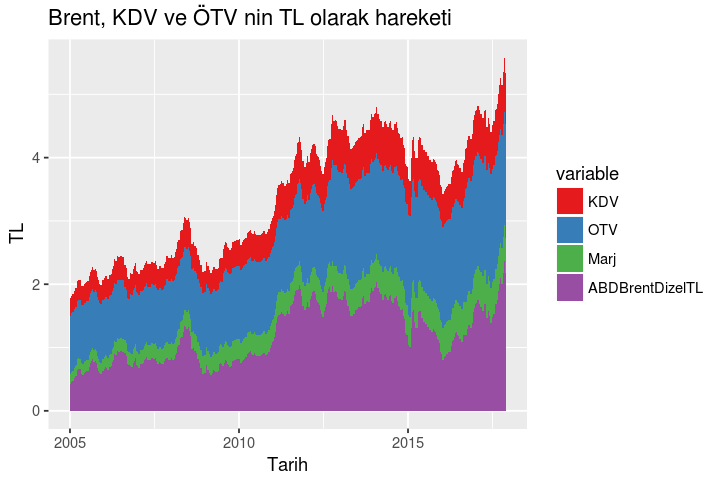

In [240]:
# head(df)
ggplot(df, aes(x = time, y = value)) +     
   geom_area(aes(fill = variable)) +
   scale_fill_brewer(palette="Set1") + ggtitle("Brent, KDV ve ÖTV nin TL olarak hareketi") +
   xlab("Tarih") +ylab("TL")

Bir de toplamdaki oranlar olarak çizdirelim

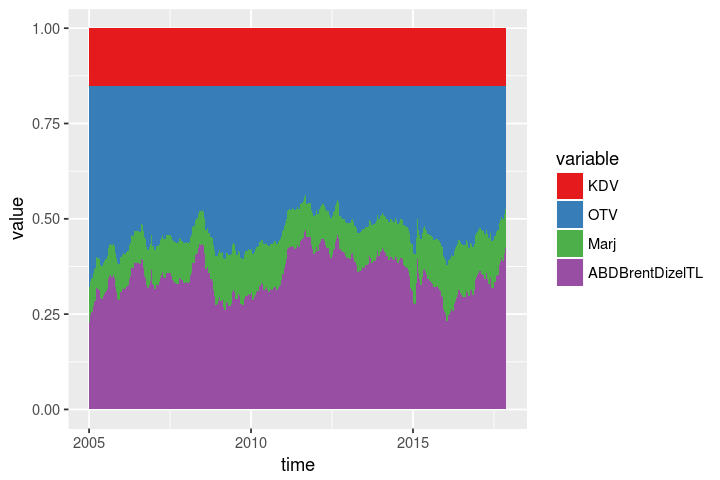

In [200]:
# http://www.sthda.com/english/wiki/be-awesome-in-ggplot2-a-practical-guide-to-be-highly-effective-r-software-and-data-visualization
ggplot(df, aes(x = time, y = value)) + 
  geom_area(aes(fill = variable),position="fill") +
  scale_fill_brewer(palette="Set1") 

## Brent'i TL olarak hesaplamak

İlk grafikler fena olmadı,  şimdi veriler isimli bir değişken ile ikinci kısımda, günlük Brent $ fiyatı ile TL kuru çarparak, TL olarak Brent fiyatını oluşturalım. Sonrada brentTL dediğimiz bu değişkeni grafikleyelim

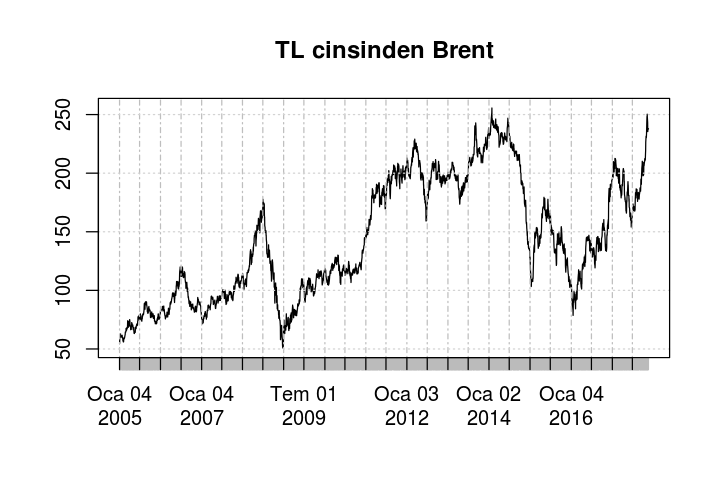

In [241]:
veriler<-NULL
veriler<-yeni
veriler$brentTL<-((veriler$Brent)*(veriler$kur))
plot(veriler$brentTL, main = "TL cinsinden Brent")

Benim en çok merak ettiğim şeylerden biri Brent $ ve TL olarak en düşük ve en yüksek değerleri ne zaman gördü. 
Verilerde 1.sütun WTI, 2.sütun Brent, en son eklediğim 11.sütun ise TL brent. 

En yüksek değerin satırını bulmak için **which.max** , en düşük değer için ise **which.min** kullanıyorum. Son olarak da tail komutu ile en son 3 günün rakamlarını alıyorum.

c ile vektör olarak istediğim sütun numaralarını girmiş oluyorum.

In [242]:
veriler[which.max(veriler$brentTL),c(1,2,11)]
veriler[which.min(veriler$brentTL),c(1,2,11)]
veriler[which.max(veriler$Brent),c(1,2,11)]
tail(veriler[-1,c(1,2,11)],3)

             WTI Brent  brentTL
2014-01-28 97.49 109.1 255.5995

             WTI Brent brentTL
2008-12-26 37.58 33.73 50.8446

              WTI  Brent  brentTL
2008-07-03 145.31 143.95 177.6055

             WTI Brent  brentTL
2017-11-16 55.14 61.18 237.5986
2017-11-17 56.21 61.34 237.2877
2017-11-20 56.21 61.34 237.9501

## Biraz artistik dokunuş

Değerleri bulduktan sonra "The Economist" dergisinin grafiklerinin teması ve renkleri ile 
* ABD \$'ı olarak Brent hareketi
* TL olarak Brent hareketini 
üst üste çizdirelim

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


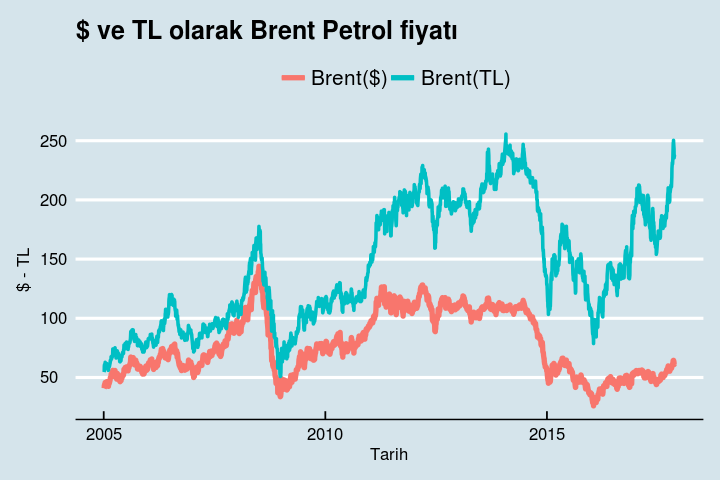

In [243]:
ggplot() + geom_line(aes(y = veriler$Brent, x = index(veriler),colour="Brent($)"), size=1.5)+
           geom_line(aes(y = veriler$brentTL, x = index(veriler),colour="Brent(TL)"), size=1) +
           ggtitle("$ ve TL olarak Brent Petrol fiyatı") + labs(x="Tarih", y="$ - TL") +
           theme_economist() + labs(color='')

Şimdi de yine "The Economist" teması ile yukarıda çizdirdiğimiz yakıt, ötv, kdv marj grafiğini çizelim

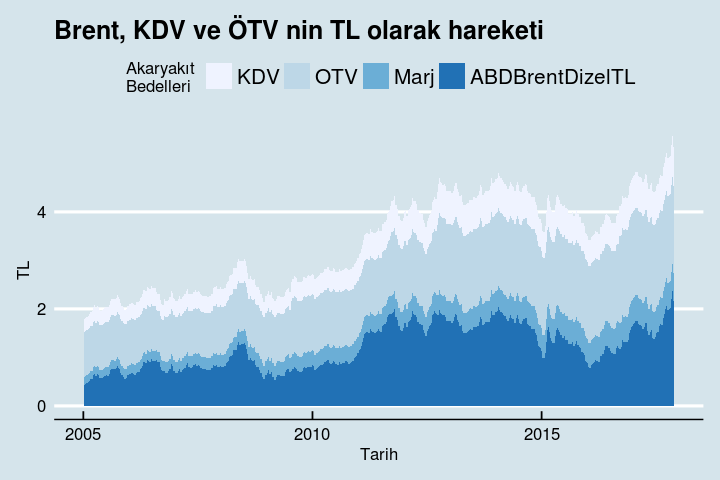

In [244]:
ggplot(df, aes(x = time, y = value), colour=value) +     
   geom_area(aes(fill = variable)) +
   ggtitle("Brent, KDV ve ÖTV nin TL olarak hareketi") +
   xlab("Tarih") +ylab("TL") +
   theme_economist() +  
  # scale_fill_brewer("Akaryakıt\nBedelleri" , labels)+
   scale_fill_brewer(name = "Akaryakıt\nBedelleri")  

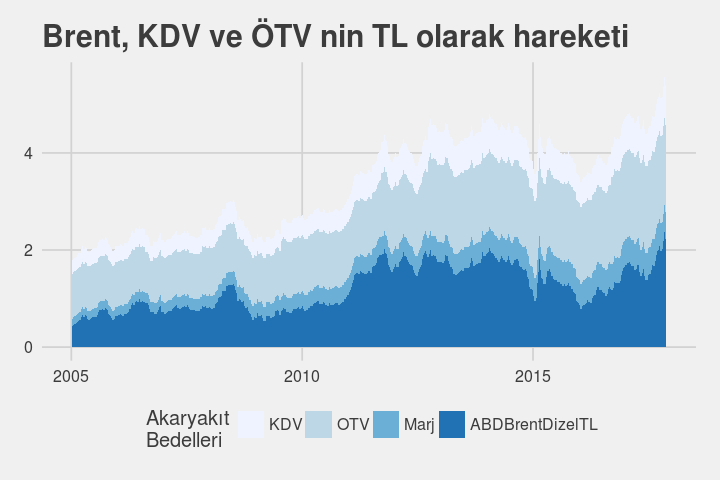

In [207]:
ggplot(df, aes(x = time, y = value)) +     
   geom_area(aes(fill = variable)) +
   ggtitle("Brent, KDV ve ÖTV nin TL olarak hareketi") +
   xlab("Tarih") +ylab("TL") +
   theme_fivethirtyeight() +  
   # scale_fill_economist() +
   scale_fill_brewer(name="Akaryakıt\nBedelleri")

## Sonuç

Bu ders biraz ağır oldu. Bu dersleri yazarken amacım en çok kendime notlar bırakmak. Bir analiz yapıyorum sonra neyi nasıl yaptığımı bulamıyorum. Bu sebeple kayıt tutmak gerekiyor.

Sırasıyla neler yaptık:
* ABD EIA veritabanından WTI, Brent ve dizel fiyatı aldık
* TCMB'den ABD döviz kuru verilerini gün gün aldık
* ÖTV, KDV ve akaryakıt fiyat marjlarını koyarak toplam akaryakıt bedeli hesapladık
* The Economist teması ile grafiklemeler yapıldı (**ggthemes** ve **ggplot2** kütüphaneleri ile)

Yorumlarını için daima mailim açık

[barissanli2@gmail.com](mailto:barissanli.com)

Bir sonraki derste buradan bir modele geçeceğiz. O sebepten son veriyi saklasak iyi olur.

In [245]:
saveRDS(veriler,"20171123-ders14sonu.rds")